# Moving the Electron Beam Along a Specified Path

Generates a set of beam positions inside a rectangular region of the scan, using pixel-based rectangle size and pixel-based step sizes. All returned coordinates are in **fractional units** ([0, 1]).

### **Inputs**

* **top_left_corner** — fractional ((x, y)) starting point of the rectangle
* **size_haadf_x**, **size_haadf_y** — full HAADF image size in pixels
* **size_pixels_x_max**, **size_pixels_y_max** — rectangle size in pixels
* **step_size_x**, **step_size_y** — sampling step in pixels along x and y

### **Output**

* `N × 2` NumPy array of fractional ((x, y)) positions inside the rectangle, clipped to ([0, 1]).



## 1. Put beam 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def get_beam_positions(
    top_left_corner=(0.5, 0.5),
    size_haadf_x=1024,
    size_haadf_y=1024,
    size_pixels_x_max=10,
    size_pixels_y_max=10,
    step_size_x=5,
    step_size_y=2,
) -> np.array: 
    a, b = top_left_corner  # fractional [0,1]

    # convert pixel-steps → fractional-steps
    frac_step_x = step_size_x / size_haadf_x
    frac_step_y = step_size_y / size_haadf_y

    # convert max pixel sizes → fractional lengths
    frac_width = size_pixels_x_max / size_haadf_x
    frac_height = size_pixels_y_max / size_haadf_y

    # generate positions
    xs = a + np.arange(0, frac_width, frac_step_x)
    ys = b + np.arange(0, frac_height, frac_step_y)

    X, Y = np.meshgrid(xs, ys, indexing="xy")
    positions = np.stack([X.ravel(), Y.ravel()], axis=-1)

    return np.clip(positions, 0.0, 1.0)


def plot_beam_positions(haadf, positions):
    h, w = haadf.shape

    # convert fractional → pixel coordinates
    px = (positions[:, 0] * w).astype(int)
    py = (positions[:, 1] * h).astype(int)

    plt.imshow(haadf, cmap='gray', origin="upper")
    plt.scatter(px, py, s=1, c='red')
    plt.show()


In [3]:
haadf = np.zeros((1024, 1024))  # black background (replace with real HAADF)
positions =  get_beam_positions(top_left_corner=(0.3, 0.4),
                            size_pixels_x_max=100,
                            size_pixels_y_max=100,
                            step_size_x=12,
                            step_size_y=3)

In [4]:
positions.shape

(306, 2)

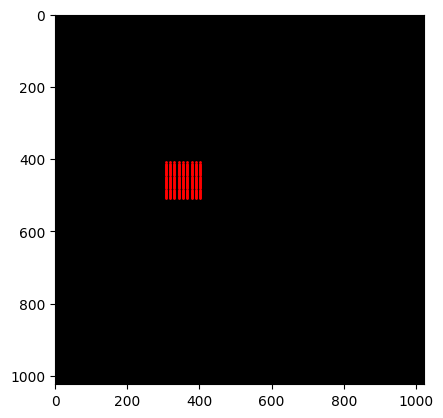

In [46]:
plot_beam_positions(haadf=haadf, positions=positions)

## 2 Put this positons on the microscope

In [40]:
from stemOrchestrator.logging_config   import setup_logging
data_folder  = "."
out_path = data_folder
setup_logging(out_path=out_path) 

In [41]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
from typing import Dict

In [42]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip_TF")
            port = port or secret.get("port_TF")



config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 40e-8,  # micro-seconds per pixel
    "haadf_resolution": 512, # square
    "out_path": "."
}

In [43]:

ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]



microscope = TemMicroscopeClient()
microscope.connect(ip, port = port)# 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])


Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
2025-11-15 12:03:21,870 - INFO - Starting microscope initialization...
2025-11-15 12:03:21,881 - INFO - CETA camera initialized
2025-11-15 12:03:21,884 - INFO - HAADF detector initialized
2025-11-15 12:03:21,890 - INFO - Microscope initialization completed successfully


In [ ]:
import time

def put_positions_on_mic_raster_left_to_right(positions: np.array, num_rounds: int = 1, per_position_exposure: float = 1e-6):
    microscope.optics.blanker.unblank()
    for round in range(num_rounds):
        print(f"==========Round=========={round}")
        for pos in range(len(positions)):
            time.sleep(per_position_exposure)# delay in seconds
            
            pos_x, pos_y = positions[pos][0], positions[pos][1]
            
            #move beam
            tf_acquisition.move_paused_beam(pos_x, pos_y)

    microscope.optics.blanker.blank()
    return 






put_positions_on_mic_raster_top_to_bottom

Original (row-major):
[[1 1]
 [2 1]
 [1 2]
 [2 2]
 [1 3]
 [2 3]]

After reshape(Ny, Nx, 2):
[[[1 1]
  [2 1]]

 [[1 2]
  [2 2]]

 [[1 3]
  [2 3]]]

After transpose(1, 0, 2):  # column-major
[[[1 1]
  [1 2]
  [1 3]]

 [[2 1]
  [2 2]
  [2 3]]]

After final reshape(-1, 2):
[[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]]


In [ ]:

def put_positions_on_mic_raster_top_to_bottom(
    positions: np.ndarray,
    Nx: int,
    Ny: int,
    num_rounds: int = 1,
    per_position_exposure: float = 1e-6,
):
    grid = positions.reshape(Ny, Nx, 2)
    col_major = grid.transpose(1, 0, 2).reshape(-1, 2)

    microscope.optics.blanker.unblank()
    for _ in range(num_rounds):
        for x, y in col_major:
            tf_acquisition.move_paused_beam(x, y)
            time.sleep(per_position_exposure)
    microscope.optics.blanker.blank()


In [ ]:
## take haadf finally
# get haadf from mic
# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=haadf_exposure, resolution=haadf_resolution
)

HAADF_tiff_to_png(haadf_tiff_name)
haadf = haadf_np_array

W, H = haadf.shape

In [ ]:
## plot positons
positions = get_beam_positions( top_left_corner=(0.5, 0.5),
                    size_haadf_x=W,
                    size_haadf_y=H,
                    size_pixels_x_max=10,
                    size_pixels_y_max=10,
                    step_size_x=5,
                    step_size_y=2,)



In [ ]:
plot_beam_positions(haadf=haadf, positions=positions)

In [ ]:
# save positons in disk
np.save(f"{out_path}pixel_pos.npy", positions)

In [ ]:
# run beam in the pattern
put_positions_on_mic(positions=positions, num_rounds=1, per_position_exposure=1e-6)

In [ ]:
## take haadf finally
# get haadf from mic
# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=haadf_exposure, resolution=haadf_resolution
)

HAADF_tiff_to_png(haadf_tiff_name)
haadf = haadf_np_array



## Later. Now Lets get localised haadf in the same box:
- haadf resolution:
    - size_x
    - size_y
- exposure- fast


In [ ]:
# from autoscript_tem_microscope_client.structures import adva
from autoscript_tem_microscope_client.structures import StemAcquisitionSettings

In [ ]:
microscope.acquisition.acquire_stem_images_advanced

In [ ]:
## also get 4dstem acquisition AS-1.15 